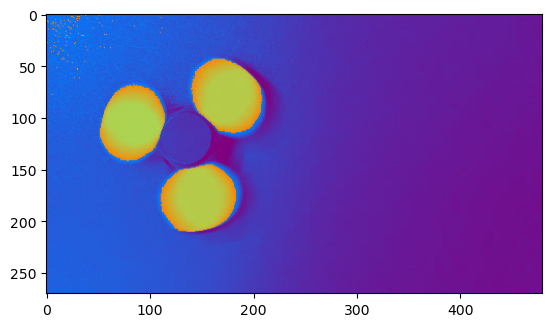

In [14]:
# Import module
import cv2
import numpy as np
#from dataPath import DATA_PATH
import matplotlib.pyplot as plt
%matplotlib inline
import os
__location__ = os.path.realpath(os.getcwd())
filename=os.path.join(__location__, 'GreenBG_Yellow.avi')
bgname=os.path.join(__location__, 'RedBG_Yellow.avi')

#Video Capture
cap = cv2.VideoCapture(filename)
# Check if camera opened successfully
if (cap.isOpened()== False): 
  print("Error opening video stream or file")
 
#Read the first frame 
ret, frame = cap.read() #ret is True or False
(rf,cf,chf)=frame.shape

capbg = cv2.VideoCapture(bgname)
ret, background = capbg.read()
capbg.release()
(rbg,cbg,chbg)=background.shape
locr1=int(rbg/2-rf/2)
locr2=int(rbg/2+rf/2)
locc1=int(cbg/2-cf/2)
locc2=int(cbg/2+cf/2)
background=128-background[locr1:locr2,locc1:locc2,:]
bgr,bgg,bgb=cv2.split(background)
background=cv2.merge((255-bgg,128-bgg,bgg))

plt.imshow(background[:,:,::-1])

def drawRectangle(action, x, y, flags, userdata):
  # Referencing global variables 
  global columnTL, rowTL, columnBR, rowBR, selectPatch, LHue, HHue, HueTol, meanHue
  # Action to be taken when left mouse button is pressed
  if action==cv2.EVENT_LBUTTONDOWN:
    cornerTL=[(x,y)]
    columnTL=x
    rowTL=y
        
    # Action to be taken when left mouse button is released
  elif action==cv2.EVENT_LBUTTONUP:
    cornerBR=[(x,y)]
    columnBR=x
    rowBR=y
    
    if selectPatch==0:
  # Draw the rectangle
        cv2.rectangle(frame, (columnTL, rowTL), (columnBR, rowBR), (0, 255, 128), thickness=3, lineType=cv2.LINE_8);
        targetPatch=frame[rowTL:rowBR, columnTL:columnBR]
        hsvPatch = cv2.cvtColor(targetPatch,cv2.COLOR_BGR2HSV)
        meanHue=np.mean(hsvPatch[:,:,0])
        LHue=np.clip(meanHue-HueTol,0,180)
        HHue=np.clip(meanHue+HueTol,0,180)
        
        selectPatch=1
        
def chromaticmatting(frame):
    global LHue, HHue
    # Laterally invert the image / flip the image
    img = frame.copy()
    # converting from BGR to HSV color space
    hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    # Range for green
    lower_grn = np.array([LHue,100,20])
    upper_grn = np.array([HHue,255,255])
    
    #Define green mask
    mask = cv2.inRange(hsv, lower_grn, upper_grn)
    #Segment out green mask
    mask1 = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3,3),np.uint8))
    mask1 = cv2.morphologyEx(mask, cv2.MORPH_DILATE, np.ones((3,3),np.uint8))
    #creating an inverted mask to segment out the cloth from the frame
    mask2 = cv2.bitwise_not(mask1)
    #Segmenting the cloth out of the frame using bitwise and with the inverted mask
    res1 = cv2.bitwise_and(img,img,mask=mask2)
    # creating image showing static background frame pixels only for the masked region
    res2 = cv2.bitwise_and(background, background, mask = mask1)
    #Generating the final output
    final_output = cv2.addWeighted(res1,1,res2,1,0)
    return final_output

def nothing(x):
    pass


#Display the video (in python)
# Read until video is completed
k=0
selectPatch=0
#Patch Hue range
LHue=40
HHue=70
meanHue=55
HueTol=5
preTol=5

panel=np.zeros((15,700),np.uint8)
cv2.imshow("Hue Tolerance", panel)
cv2.namedWindow("Hue Tolerance")
cv2.createTrackbar("Tolerance", "Hue Tolerance", 5, 125, nothing)

cv2.namedWindow("Video Output")
# highgui function called when mouse events occur
cv2.setMouseCallback("Video Output", drawRectangle)

while(cap.isOpened()):
  
  # Capture frame-by-frame
  ret, frame = cap.read()  # Read the immediate frame

  if ret == True:
    if selectPatch==0:
        cv2.putText(frame,'''Choose top left corner, and drag to select a patch color for background removal''' ,
              (10,30), cv2.FONT_HERSHEY_SIMPLEX, 
              0.7,(255,255,255), 2 );  
        
    if selectPatch==1:
        
        
        HueTol=cv2.getTrackbarPos("Tolerance", "Hue Tolerance")
        LHue=np.clip(meanHue-HueTol,0,180)
        HHue=np.clip(meanHue+HueTol,0,180)
        
        frame=chromaticmatting(frame)
        cv2.putText(frame,'''Enter [Esc] to close the window''' ,
              (10,30), cv2.FONT_HERSHEY_SIMPLEX, 
              0.7,(255,255,255), 2 );  
        
        
    cv2.imshow("Hue Tolerance", panel)
    
    cv2.imshow("Video Output", frame)    
    # Wait for 25 ms before moving on to the next frame
    # This will slow down the video
    k=cv2.waitKey(25)
    
    if k==27:
        cap.release()
        break
  # Renew the video
  else: 
    
    cap = cv2.VideoCapture(filename)

# When everything done, release the VideoCapture and VideoWriter objects
cv2.destroyAllWindows()